## Introduction
The Franz Butler Vineyard (TM) would like to predict how much they can charge for a bottle of wine from their vineyard. The local market has three main price points: Boxed, Good, and Fancy.  Each of these categories contains two sub-categories that can affect pricing, albeit not as significantly. They would first like to compare various categorical Machine Learning models to decide the most accurate model for predicting the quality of a wine, based on 11 testable features.

In [70]:
# Run for required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from warnings import filterwarnings 
filterwarnings("ignore")

## Dataset Description
Our dataset consists of quantitative descriptions of various wines. There are 1599 wines sampled. We have 11 features for each observation, each with a numeric rating of a physiochemical property of the wine such as alcohol content and acidity. The output variable we seek to predict corresponds to the quality rating of each wine, from sensory data. There are no missing values. 

A closer inspection of the quality outputs shows a total of 6 integer categories (3-8) as no wine on the list scored a 1, 2, 9, or 10. However there is also a clear partition, based on the distibution, into 3 subcategories (3-4, 5-6, 7-8). This leads to the hypothesis that we can look at predicting if a wine is of quality Box, Good, or Fancy using these supercategories. By looking at the frequency of each quality rating below, we see that most wines will fall into the Good category under this classification. For some applications, this may be a precise enough classification. Since the more difficult task will likely be differentiating between wines rated 5 or 6, we proceed with all 6 categories, but we also compare our results with those we would obtain from the 3 category version of the problem.

In [72]:
#Read in data
filename = "./winequality-red.csv"
df = pd.read_csv(filename, delimiter = ';')
X = df.values[:,0:-1]
y = df.values[:,-1]

#Normalize Feature Data
X = preprocessing.normalize(X, axis = 0)

#Print dataset
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


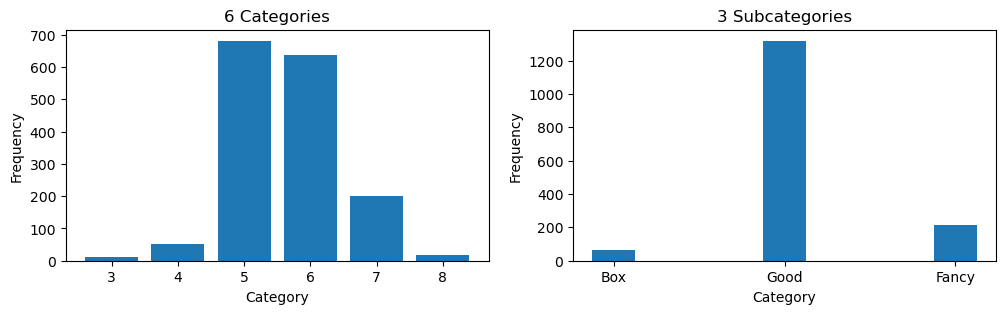

In [73]:
# Plot 
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.bar(d.keys(), d.values())
plt.title("6 Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")
ax = plt.subplot(122)
plt.bar(d_threecat.keys(), d_threecat.values(), width=.25)
plt.title("3 Subcategories")
plt.xlabel("Category")
plt.ylabel("Frequency")
ax.set_xticks([1,2,3], names_threecat)

## Experimental Setup 
We select six estimators implemented in the scikit learn library: a Decision Tree classifier, a Random Forest classifier, an AdaBoost classifier, a K-nearest neighbors classifier, a Support Vector classifier, and a Support Vector Regression. The cost function we seek to maximize is accuracy. For the Support Vector Regression, we define accuracy to be the proportion of predicted values that, once rounded to the nearest integer, match the test values.

We use k-fold Cross Validation with k = 10. This ensures that each data point is used in both testing and training and prevents overfitting to a single test-train split. Although scikit comes with helpful tools such as cross_val_score to save us the need to actually implement a k-fold Cross Validation, because we are comparing a regressor to several classifiers and wish to customize the score of the Support Vector Regression, we do implement the Cross Validation and iterate over test-train splits. We use scikit's KFold to create test-train split indices (after shuffling the data) and for each test-train split obtain an accuracy for each estimator. We compare the array of accuracy values obtained for each estimator in the box plots below, and we further include a table of the accuracies averaged over the k folds.

We repeat the above process twice: once with our six category experiment, and once with only three categories for our predictions.

Since we are only comparing our six estimators and selecting the one with the best average performance, we do not implement nested resampling. In order to get an unbiased performance estimate for our selected estimator, we would in theory want to test it on data not seen by the selection process, and hence would implement a nested resampling. Further, after experimenting with feature selection, we opted to keep all the features rather than performing feature selection. The only preprocessing we do is to normalize the data by feature using the L2 norm.

,Accuracy (6 categories),Accuracy (3 categories)
Decision Tree,0.625366,0.816152
Random Forest,0.697952,0.870542
AdaBoost,0.524104,0.752366
Knn,0.567897,0.834292
SVM,0.579721,0.830523
SVR,0.888671,0.977476


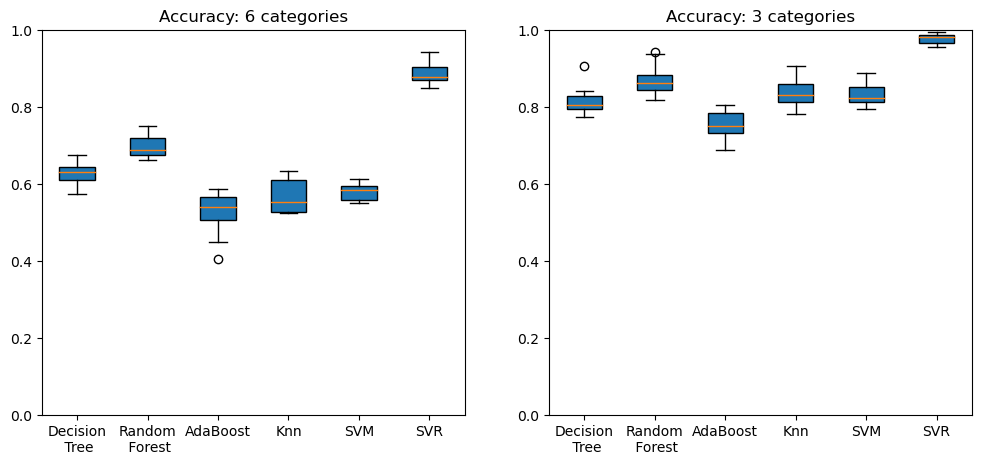

In [75]:
# ML Estimators to test
names = ["Decision\n Tree",
         "Random\n Forest",
         "AdaBoost",
         "Knn",
         "SVM",
         "SVR"
         ]
estimators = [tree.DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier(),
              KNeighborsClassifier(),
              SVC(),
              SVR()
              ]

num_est = len(estimators)
num_kfolds = 10

# Use scikit learn KFold to create the test-train split indices, with data shuffled
kf = KFold(n_splits = num_kfolds, shuffle = True)
acc = np.zeros([num_est, num_kfolds])
acc_threecat = np.zeros([num_est, num_kfolds])

# Outer loop iterates over the K folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X[train_index, :]
    X_test = X[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]
    y_train_threecat = y_threecat[train_index]
    y_test_threecat = y_threecat[test_index]
    # inner loop iterates over the estimators
    for name, est in zip(names, estimators):
        model = est.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        temp = [abs(y_pred - y_test) < 1] 
        acc[estimators.index(est), i] = sum(sum(temp))/len(y_test)
        
        # Three categories part
        model_threecat = est.fit(X_train, y_train_threecat)
        y_pred_threecat = model.predict(X_test)
        temp = [abs(y_pred_threecat - y_test_threecat) < 1]
        acc_threecat[estimators.index(est), i] = sum(sum(temp))/len(y_test_threecat)

# Plot results
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.boxplot(acc.T, patch_artist=True, labels=names)
plt.ylim([0,1])
plt.title("Accuracy: 6 categories")
plt.subplot(122)
plt.boxplot(acc_threecat.T, patch_artist=True, labels=names)
plt.ylim([0,1])
plt.title("Accuracy: 3 categories")

# Create table of mean accuracy for each estimator
acc_means = np.average(acc, axis = 1)
acc_means_threecat = np.average(acc_threecat, axis = 1)
names2 = ["Decision Tree",
         "Random Forest",
         "AdaBoost",
         "Knn",
         "SVM",
         "SVR"
         ]
means = np.column_stack((acc_means, acc_means_threecat))
table_means = pd.DataFrame(data = means, columns =['Accuracy (6 categories)', 'Accuracy (3 categories)'], index = names2)
table_means

## Results
The best performing estimator in this test is the Support Vector Regression with nearly 90% accuracy. Of the classifiers tested, the Random Forest model has the highest accuracy of roughly 70%. When we look at the accuracy of each estimator after lumping wine qualities into our Boxed, Good, and Fancy categories, we see that each of the mean accuracies is improved (as we would expect) and the top performers are still the Support Vector Regression and Random Forest. The worst estimator is AdaBoost, no matter how we slice it, but the three classifiers in the middle are ranked differently depending on how we combine categories. Whether we would like to very accurately predict whether our wine is Boxed, Good, or Fancy, or predict its specific score on the ten point scale, we end up with the same best estimator. In conclusion, we recommend the Franz Butler Vineyard pursue a Support Vector Regression to determine the pricing point of future wine production.

## Resources Used
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html